## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera Calibration

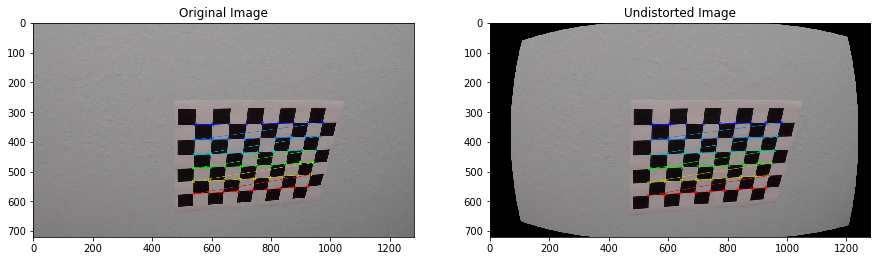

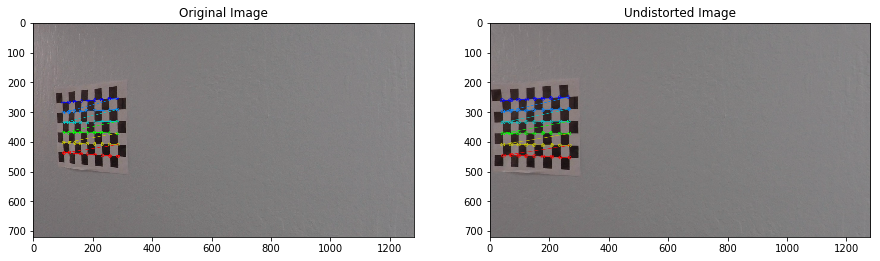

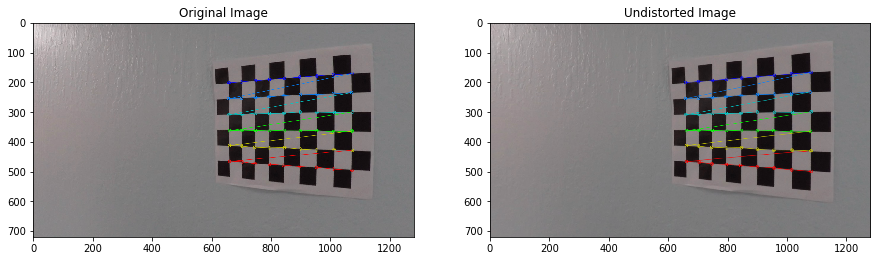

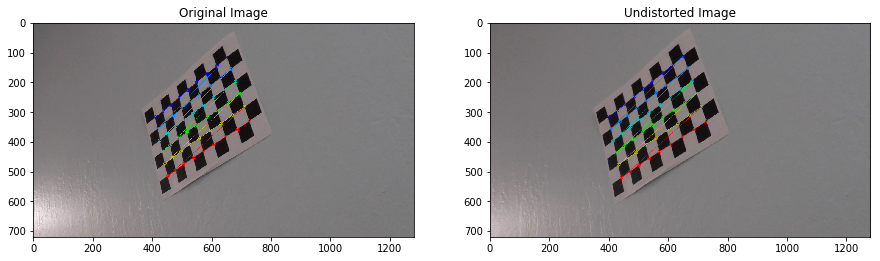

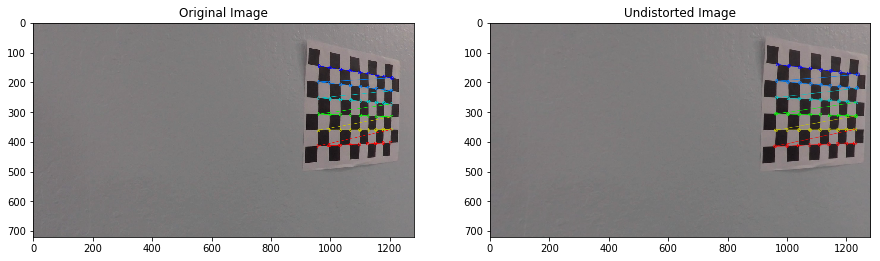

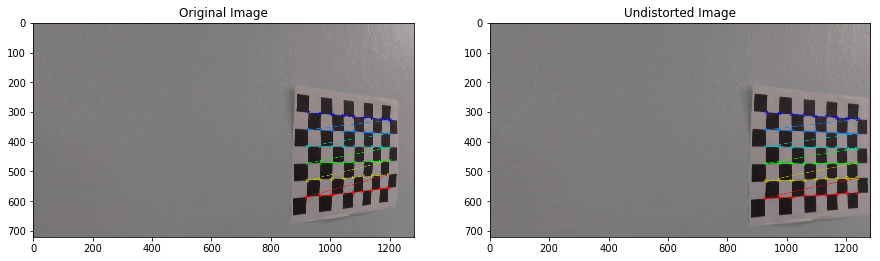

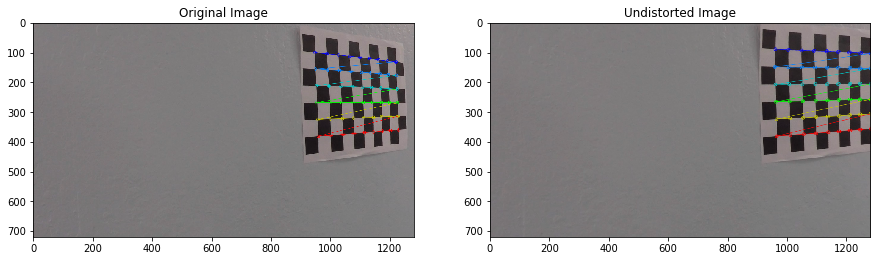

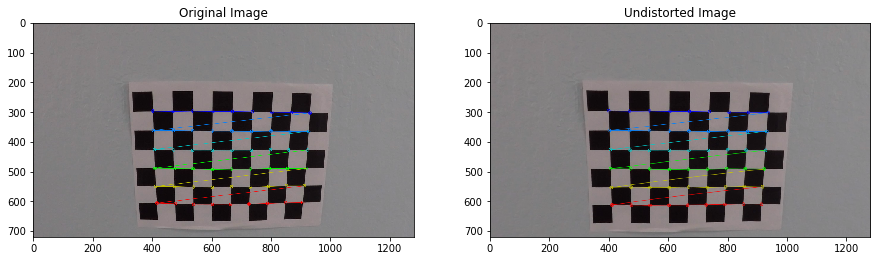

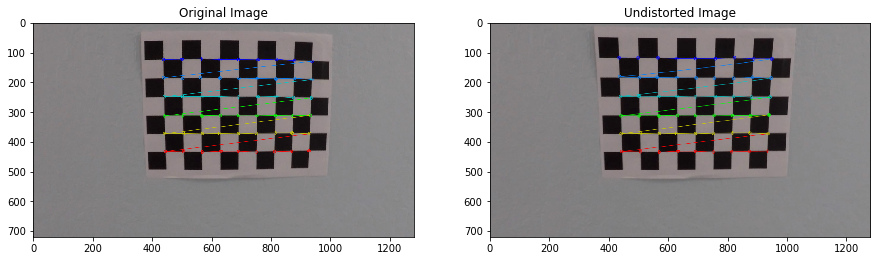

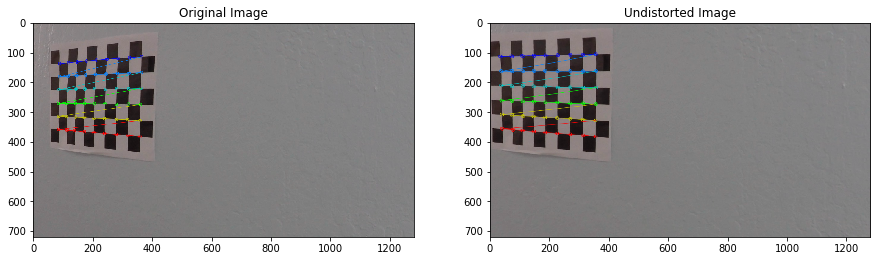

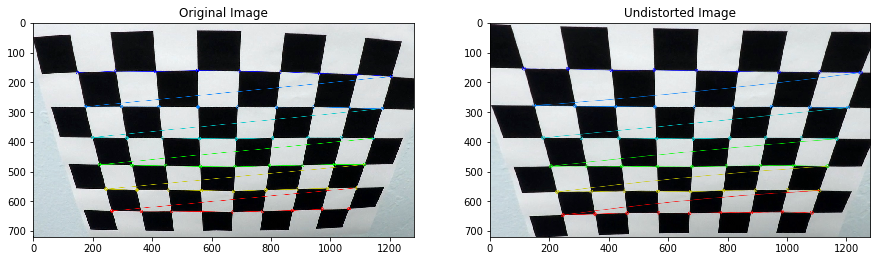

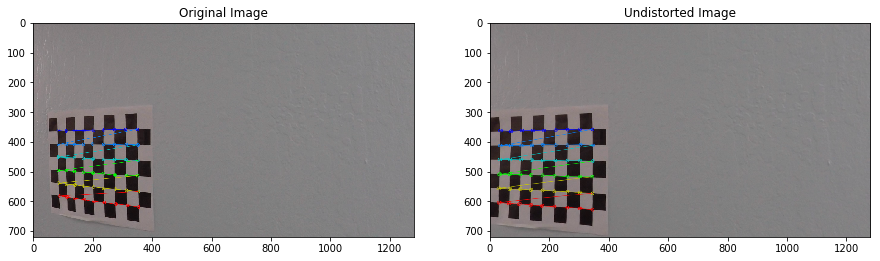

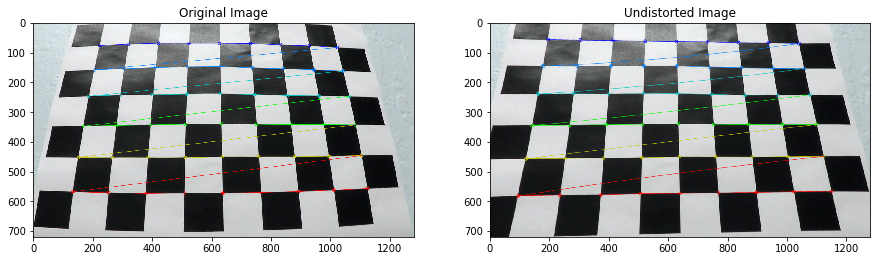

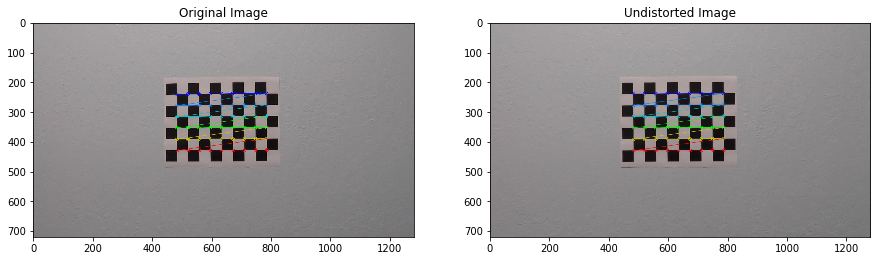

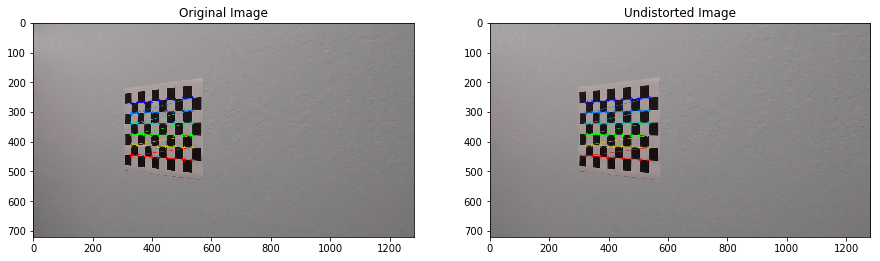

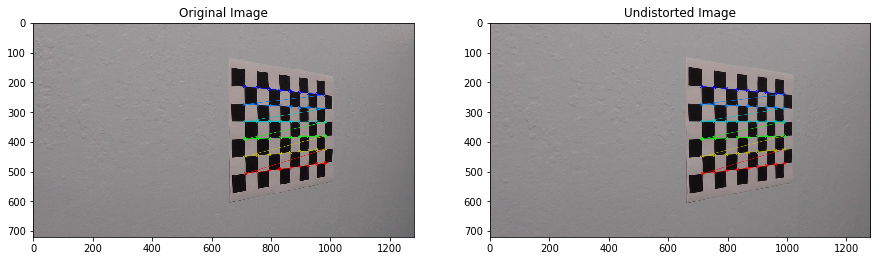

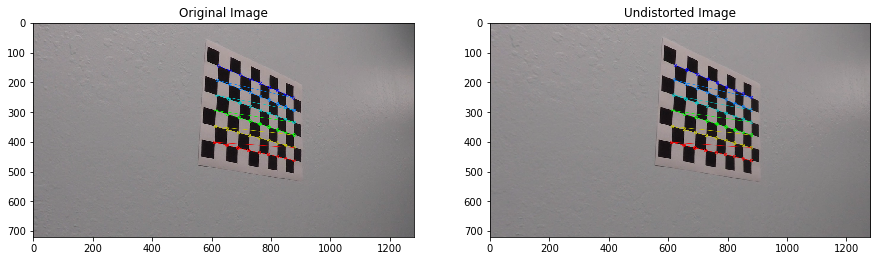

In [9]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    name = fname.split('\\')[1]
    name = name.split('.')[0]
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
#    f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
#        cv2.imwrite('../output_images/%s.jpg'%(name), dst)
        f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,6))
        ax1.imshow(img, cmap='gray')
        ax1.set_title('Original Image')
        ax2.imshow(dst, cmap='gray')
        ax2.set_title('Undistorted Image')

with open('../calibration.p', 'wb') as f:
            pickle.dump({
                'mtx': mtx,
                'dist': dist
            }, f)


## Create a thresholded binary image


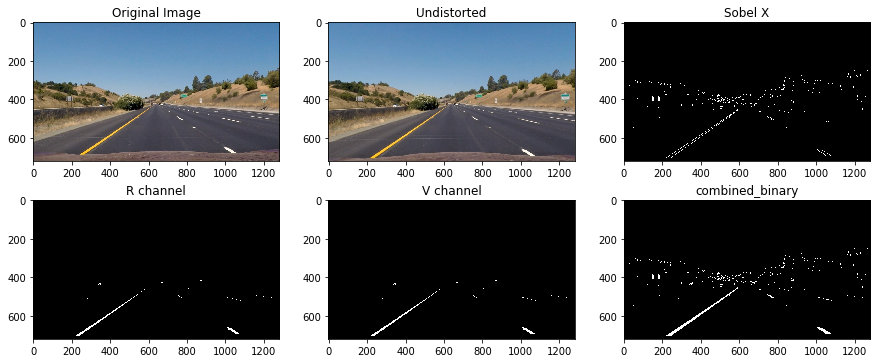

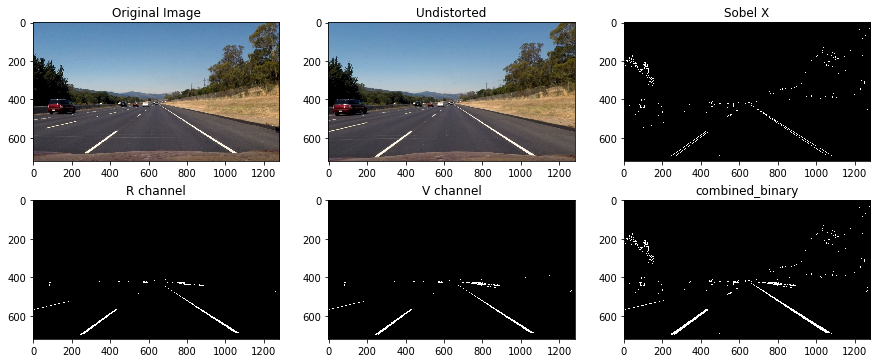

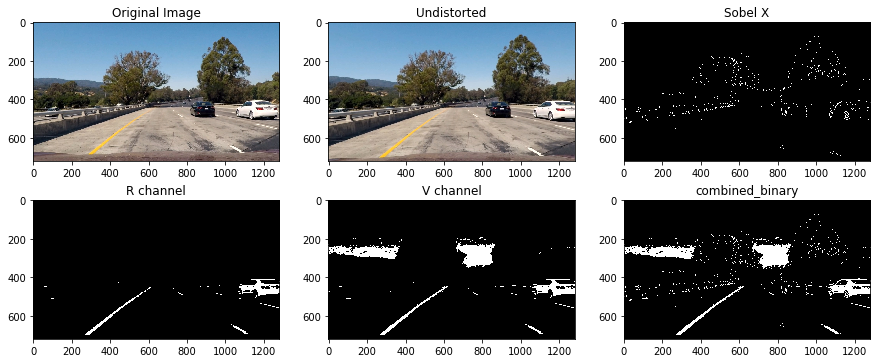

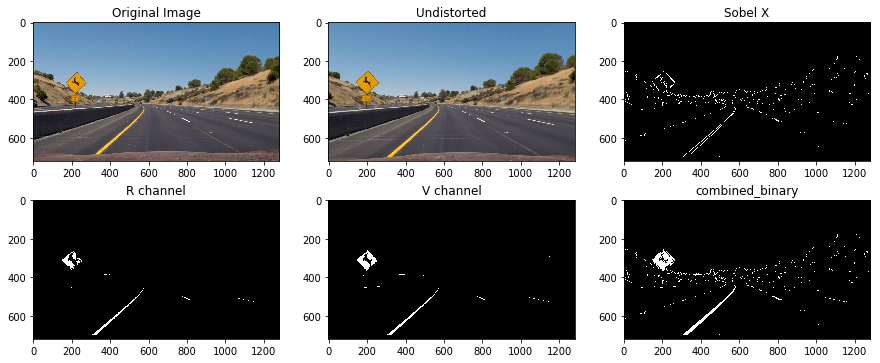

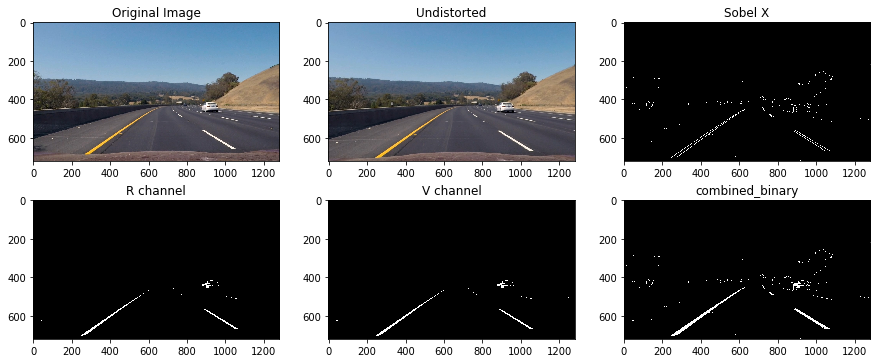

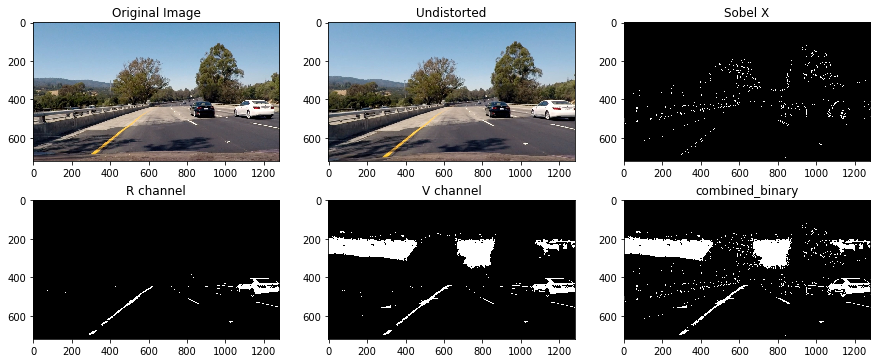

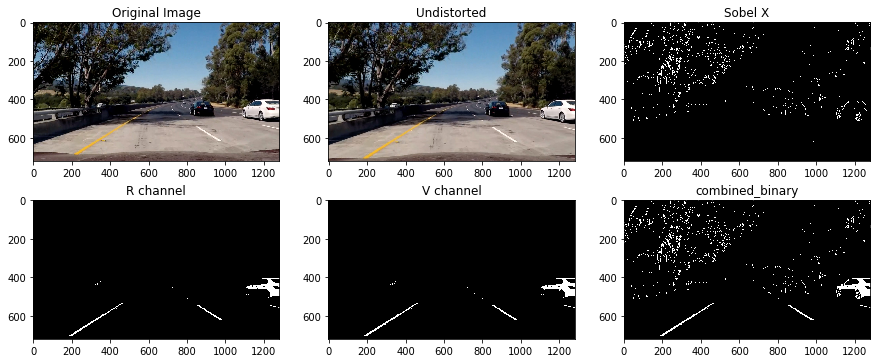

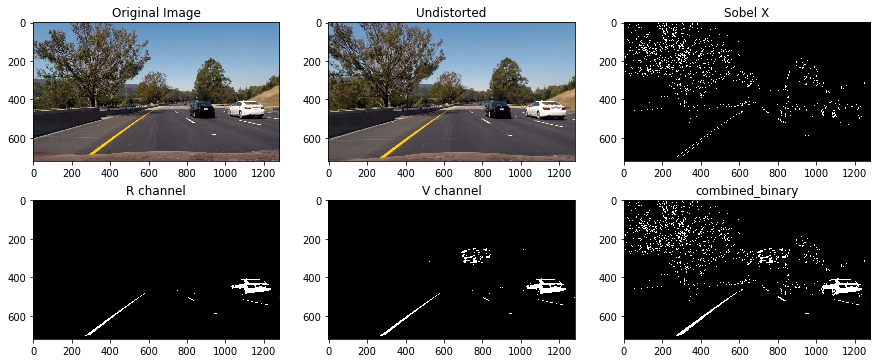

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def Undistortion(img):
    with open('../calibration.p', 'rb') as f:
        dist_pickle = pickle.load(f)
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    undist =  cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def Binary_op(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >=50) & (scaled_sobel <= 150)] = 1
   
    ax3.imshow(sx_binary, cmap='gray')
    ax3.set_title('Sobel X')

    
    v_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,2]


    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >=225) & (r_channel <=255)] = 1
    ax4.imshow(r_binary, cmap='gray')
    ax4.set_title('R channel')

    

    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >=220 ) & (v_channel <=255)] = 1
    ax5.imshow(v_binary, cmap='gray')
    ax5.set_title('V channel')

    
    color_binary = 255*np.dstack(( r_binary, sx_binary, v_binary)).astype('uint8')

    combined_binary = np.zeros_like(r_channel)
    combined_binary[(r_binary == 1) | (sx_binary == 1)| (v_binary == 1)] = 1
    ax6.imshow(combined_binary, cmap='gray')
    ax6.set_title('combined_binary')
    return combined_binary

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
 
images = glob.glob('../test_images/*.jpg')
combined_list = []
img_list = []
undist_list = []
for fname in images:
    name = fname.split('\\')[1]
    name = name.split('.')[0]
    img = mpimg.imread(fname)
    img_list.append(img) 
    f, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(15,6))
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image')

    undist = Undistortion(img)
    cv2.imwrite('../output_images/undist_%s.jpg'%(name), cv2.cvtColor(undist, cv2.COLOR_RGB2BGR))
    undist_list.append(undist)
    ax2.imshow(undist, cmap='gray')
    ax2.set_title('Undistorted')

    combined_binary = Binary_op(undist)
    
    combined_list.append(combined_binary)


## Perspective Transform

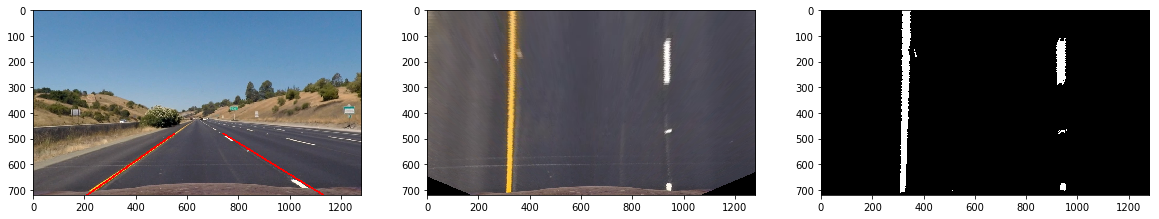

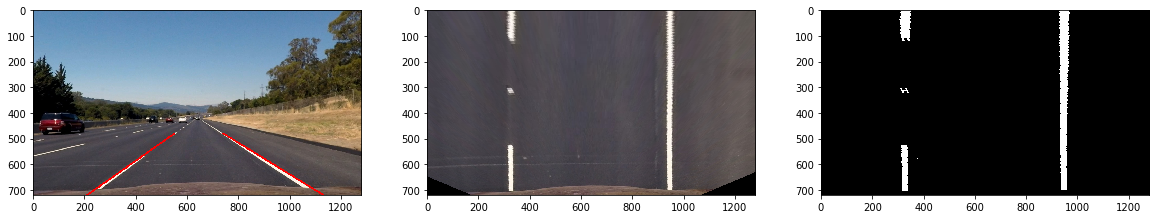

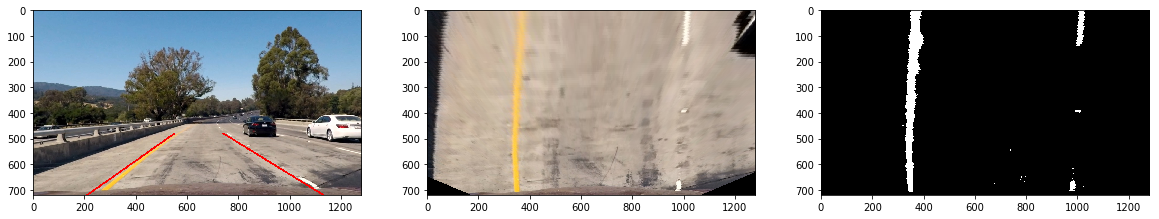

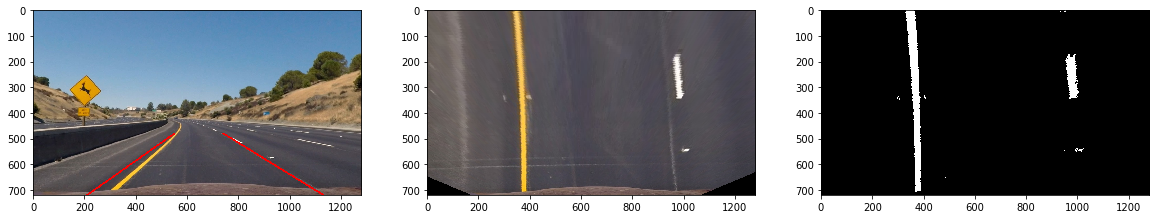

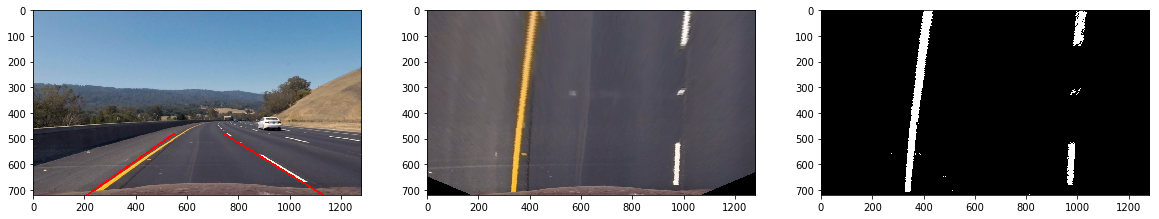

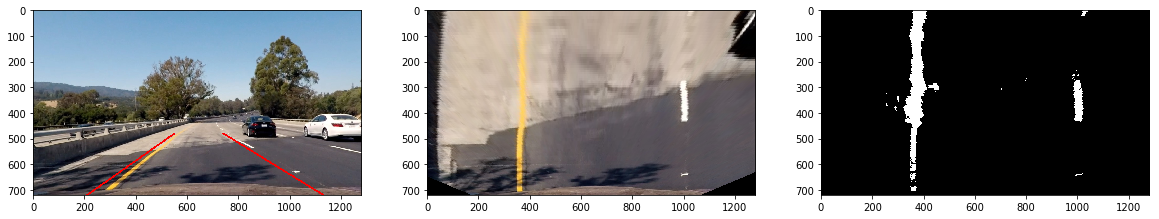

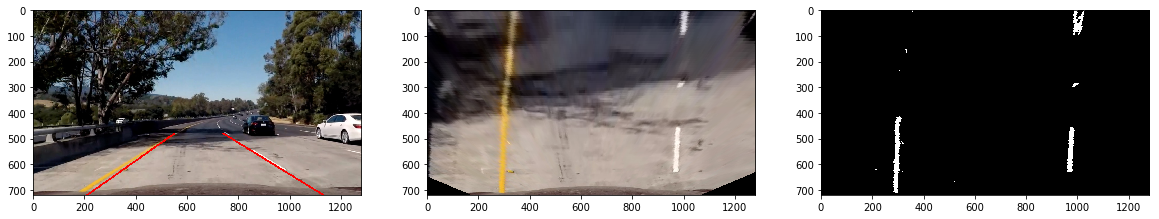

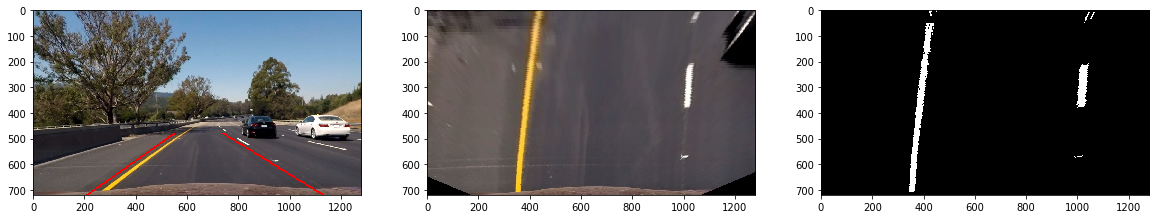

In [3]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped
warped_list = []

for i in range(len(img_list)):
    fname=images[i]
    name = fname.split('\\')[1]
    name = name.split('.')[0]
    img = undist_list[i]
    combined_binary = combined_list[i]          
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
    [[210, 720],
    [550, 480],
    [740, 480],
    [1130, 720]])
    dst = np.float32(
    [[(img_size[0] / 4),  img_size[1]],
    [(img_size[0] / 4), 0],
    [(img_size[0] * 3 / 4), 0],
    [(img_size[0] * 3 / 4),  img_size[1]]])
    perspective_M = warper(img, src, dst)
    binary_warped = warper(combined_binary, src, dst)
    vertices = np.array([[(200, img.shape[0]),(200, 0), (1100, 0), (1100, img.shape[0])]], dtype=np.int32)
    binary_warped=region_of_interest(binary_warped, vertices)
    warped_list.append(binary_warped)
    plt.figure(figsize=(20,20)) 
    plt.subplot(1,3,1)
    red = (255,0,0)
    lines = cv2.line(img,(210, 720),(550, 480),red,5)
    lines = cv2.line(lines,(740, 480),(1130,720),red,5)
    plt.imshow(lines,cmap='gray')

    plt.subplot(1,3,2)
    plt.imshow(perspective_M,cmap='gray')
    plt.subplot(1,3,3)
    cv2.imwrite('../output_images/bird_view_%s.jpg'%(name), cv2.cvtColor(perspective_M, cv2.COLOR_RGB2BGR))
    plt.imshow(binary_warped,cmap='gray')
 

## Implement Sliding Windows and Fit a Polynomial

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def Sliding_Window(binary_warped,image):
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    
     
    f, (ax1) = plt.subplots(1,1, figsize=(5, 5))
    f.tight_layout()                                                        
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    

    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#    print(left_curverad, right_curverad)

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#    print(left_curverad, 'm', right_curverad, 'm')
    
    # Calculate the position of the vehicle
    center = (640 - ((rightx_int+leftx_int)/2))

    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
    [[210, 720],
    [550, 480],
    [740, 480],
    [1130, 720]])
    dst = np.float32(
    [[(img_size[0] / 4),  img_size[1]],
    [(img_size[0] / 4), 0],
    [(img_size[0] * 3 / 4), 0],
    [(img_size[0] * 3 / 4),  img_size[1]]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    cv2.putText(result, 'Distance from center: {:.2f}m '.format(center*3.7/700), (430,630),
                 fontFace = 16,fontScale=1,  color=(255,255,255), thickness = 1)
    cv2.putText(result, 'Radius of curvature: {}m'.format(int((left_curverad + right_curverad)/2)), (430,670),
                 fontFace=16, fontScale=1, color=(255,255,255), thickness = 1)    
    f, (ax2) = plt.subplots(1,1, figsize=(5, 5))
    f.tight_layout()
    
    ax2.imshow(result)
    ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
    ax2.text(430,630, 'Distance from center: {:.2f}m '.format(center*3.7/700),
                 style='italic', color='blue', fontsize=8)
    ax2.text(430, 670, 'Radius of curvature: {}m'.format(int((left_curverad + right_curverad)/2)),
             style='italic', color='blue', fontsize=8)
    return result

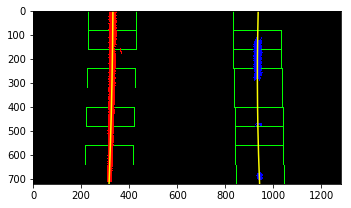

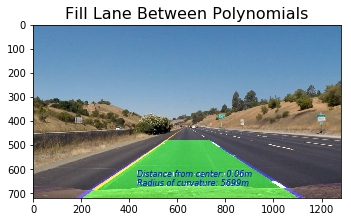

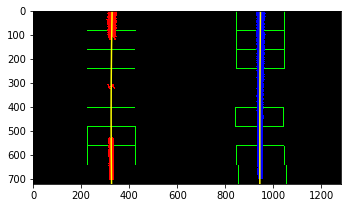

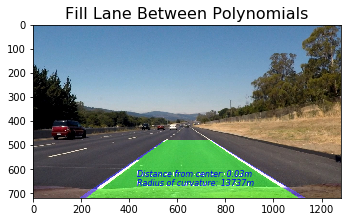

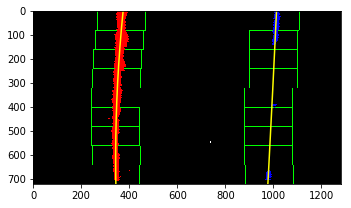

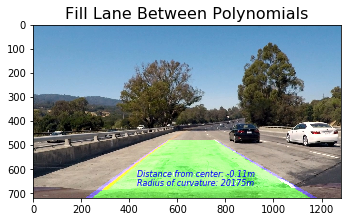

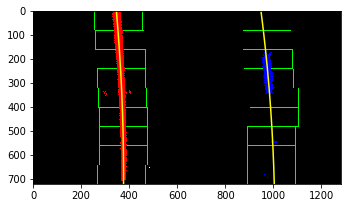

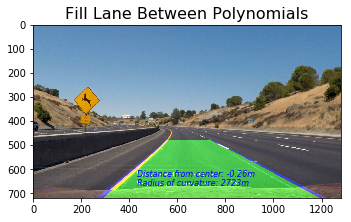

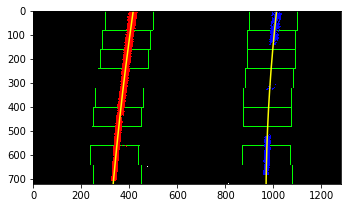

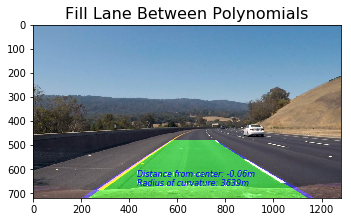

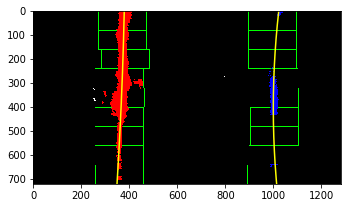

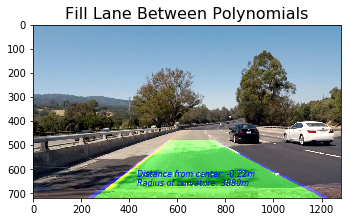

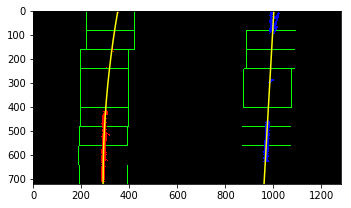

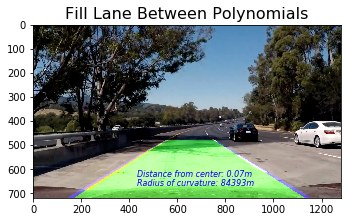

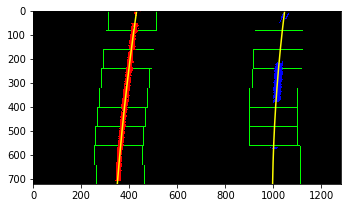

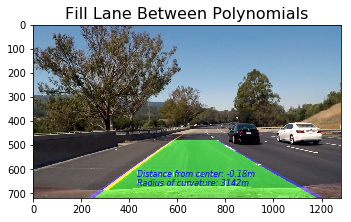

In [8]:
for i in range (0,len(warped_list)):
    binary = warped_list[i]
    image = img_list[i]
    Sliding_Window(binary,image)

## Drawing

## Testing on Video

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video(img):
    img = Undistortion(img)
    binary = Binary_op(img)
    src = np.float32(
    [[210, 720],
    [550, 480],
    [740, 480],
    [1130, 720]])
    dst = np.float32(
    [[(img_size[0] / 4),  img_size[1]],
    [(img_size[0] / 4), 0],
    [(img_size[0] * 3 / 4), 0],
    [(img_size[0] * 3 / 4),  img_size[1]]])
    warped = warper(binary,src,dst)
    vertices = np.array([[(200, 720),(200, 0), (1100, 0), (1100, 720)]], dtype=np.int32)
    warped=region_of_interest(warped, vertices)
    result = Sliding_Window(warped,img)
    return  result

input_video = "project_video.mp4"
output_video = 'output_{}'.format(input_video)
clip = VideoFileClip(input_video)
clip.fl_image(process_video).write_videofile(output_video, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:15<00:00,  4.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

